# Data Exploration

In [25]:
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

Load Data:

In [2]:
complete2014Data = pd.DataFrame.from_csv('cache/complete2014Data.csv')

### 1. Get Basic Information About Dataset

Infos such as size of data, number of flights per months, number of delays in total and average.

*A flight delay is a when an airline flight takes off and/or lands later than its scheduled time. The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time.*

Source: https://en.wikipedia.org/wiki/Flight_cancellation_and_delay

Percentage of flights with arrival delays and departure delays:

In [3]:
departureDelayed = complete2014Data.DEP_DELAY >= 15
arrivalDelayed = complete2014Data.ARR_DELAY >= 15
bothDelayed = (complete2014Data.DEP_DELAY >= 15) & (complete2014Data.ARR_DELAY >= 15)

print "Percentage departure delays out of all flights: ", sum(departureDelayed)/float(len(complete2014Data))
print "Percentage arrival delays out of all flights: ", sum(arrivalDelayed)/float(len(complete2014Data))
print "Arrival delayed if departure was already delayed: ", sum(bothDelayed)/float(sum(arrivalDelayed))

Percentage departure delays out of all flights:  0.205397048117
Percentage arrival delays out of all flights:  0.213156062972
Arrival delayed if departure was already delayed:  0.78331081604


As we can see above, roughly 1/5 of all flights have a delayed departure, almost the same percentage of flights arrives late at the destination. Only a small percentage of delayed departures manage to catch up during the flight, since more than 78% of the delayed arrivals already suffered from a delayed departure.

###2. What Airports are the Worst/Best?

Airport ranking (origin/destination) regarding delay times. For origin airports, we consider departure delay, and for destination airport we consider arrival delay.

Differentiate between different delay types (weather, security, etc.), e.g. are certain airports more affected by weather delays than others?

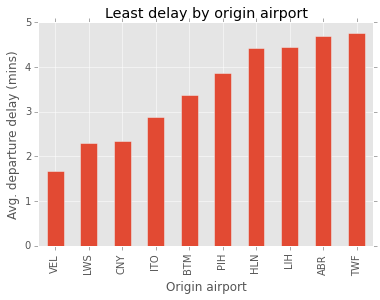

In [41]:
threshold = 365 # Minimum number of flights per day

OADelay = complete2014Data[['ORIGIN', 'DEP_DELAY']] 
OADelay = OADelay[OADelay.DEP_DELAY.notnull()] # Ignore entries with NaN values
OADelay.ix[(OADelay.DEP_DELAY < 0), 'DEP_DELAY'] = 0 # Don't consider early departures

gbOA = OADelay.groupby('ORIGIN').agg(['mean', 'count'])
gbOA = gbOA[gbOA['DEP_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day
gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = True)
ax = gbOA.head(10)['DEP_DELAY']['mean'].plot(kind='bar')
ax.set_ylabel('Avg. departure delay (mins)')
ax.set_xlabel('Origin airport')
ax.set_title('Least delay by origin airport')


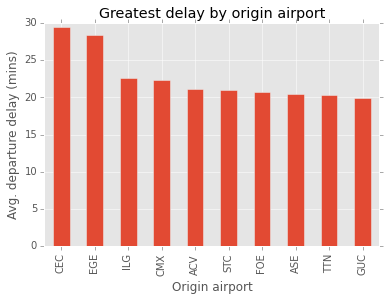

In [42]:
gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = False)
ax2 = gbOA.head(10)['DEP_DELAY']['mean'].plot(kind='bar')
ax2.set_ylabel('Avg. departure delay (mins)')
ax2.set_xlabel('Origin airport')
ax2.set_title('Greatest delay by origin airport')

In [48]:
# print complete2014Data.columns

# complete2014Data[['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY']]

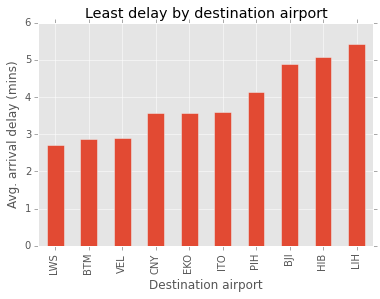

In [44]:
DADelay = complete2014Data[['DEST', 'ARR_DELAY']] 
DADelay = DADelay[DADelay.ARR_DELAY.notnull()] # Ignore entries with NaN values
DADelay.ix[(DADelay.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures

gbDA = DADelay.groupby('DEST').agg(['mean', 'count'])
gbDA = gbDA[gbDA['ARR_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = True)

ax = gbDA.head(10)['ARR_DELAY']['mean'].plot(kind='bar')
ax.set_ylabel('Avg. arrival delay (mins)')
ax.set_xlabel('Destination airport')
ax.set_title('Least delay by destination airport')

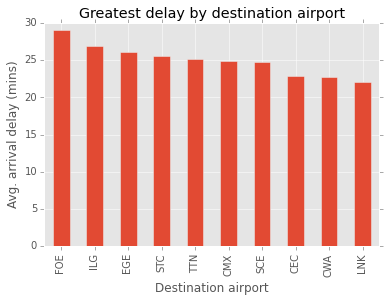

In [45]:
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = False)
ax2 = gbDA.head(10)['ARR_DELAY']['mean'].plot(kind='bar')
ax2.set_ylabel('Avg. arrival delay (mins)')
ax2.set_xlabel('Destination airport')
ax2.set_title('Greatest delay by destination airport')

###3. What Airlines are the Worst/Best? What About Specific Routes?

Delay ranking regarding airlines and routes. We filter out any inactive airlines as it's no longer relevant.

In [49]:
# Get a list of active airlines by their IATA codes
activeAirlines_l = [l.strip() for l in open("data/cur_airlines.txt","r").readlines()]
activeAirlines = dict( zip(activeAirlines_l, range(len(activeAirlines_l))) )

AA = complete2014Data[complete2014Data.UNIQUE_CARRIER.isin(activeAirlines)]
AA.head()


,index,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
0,0,2014-01-01,AA,N338AA,1,JFK,LAX,900,914,14,...,2475,NaN,NaN,NaN,NaN,NaN,1987,BOEING,40.633333,-73.783333
1,1,2014-01-02,AA,N338AA,1,JFK,LAX,900,857,-3,...,2475,NaN,NaN,NaN,NaN,NaN,1987,BOEING,40.633333,-73.783333
2,2,2014-01-03,AA,N323AA,1,JFK,LAX,900,NaN,NaN,...,2475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.633333,-73.783333
3,3,2014-01-04,AA,N327AA,1,JFK,LAX,900,1005,65,...,2475,0,59,0,0,0,1986,BOEING,40.633333,-73.783333
4,4,2014-01-05,AA,N323AA,1,JFK,LAX,900,1050,110,...,2475,0,110,0,0,0,NaN,NaN,40.633333,-73.783333


###4. How Does Weather Affect Delays?

Combine with external weather data and show interesting correlations